# Data preparation


## Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Download data
Getting the data from google street view api

In [0]:
# _*_ coding: utf-8 _*_
__author__ = 'Administrator'
import numpy as np
import pandas as pd
import urllib
import urllib.request
from urllib.request import urlopen
import threading
from optparse import OptionParser
from bs4 import BeautifulSoup
import sys
import re
from urllib.parse import urljoin
import urllib.parse
import queue
import os
# import Queue
import hashlib
import gzip
import random
import matplotlib.pyplot as plt
import json, requests

In [0]:
path ='/content/gdrive/My Drive/MScthesis/ukpostcodes.csv'
postcodes=pd.read_csv(path)#the total set of uk postcode

In [0]:
# sample = postcodes.sample(n=40000)#choose the postcode randomly
# sample.to_csv('/content/gdrive/My Drive/MScthesis/ukpostcodessample.csv')
sample=pd.read_csv('/content/gdrive/My Drive/MScthesis/ukpostcodessample.csv')

In [0]:
sample_revise=sample[['id','postcode','latitude','longitude']]
sample_revise = sample_revise.iloc[25205:40000,]
sample_revise.head()

## Download the GSV image

In [0]:
def download(url, name):
  path = '/content/gdrive/My Drive/MScthesis/randomdataset'
  #url = "https://maps.googleapis.com/maps/api/streetview?size=600x300&location=latitude value,longtitude value&heading=heading value&pitch=-0.76&key="#Your KEY"
  # save as jpg format
  conn = urlopen(url)
  f    = open(name, 'wb')
  f.write(conn.read())
  f.close()
  print('Pic Saved!')
  
  # simple_revise is the cleaned csv
for row in range(len(sample_revise)):
  eachposition =  sample_revise.iloc[row,]
  idnum        =  str(eachposition[0])
  postcode     =  str(eachposition[1])
  latitude     =  str(eachposition[2])
  longtitude   =  str(eachposition[3])
  fov          =  str(100)
  # Save to randomdataset file
  name = '/content/gdrive/My Drive/MScthesis/randomdataset/'+ idnum + "_" + postcode + "_" + latitude  + "_" + longtitude + "_" + fov + ".jpg"
  url = 'https://maps.googleapis.com/maps/api/streetview?size=640x640&location='+ latitude + ',' + longtitude +  '&fov='+ fov +  '&key="#Your KEY"'
  print(eachposition)
  print(name)
  download(url, name)
  


Output hidden; open in https://colab.research.google.com to view.

## Label the data by using OS places API
using OS places API and Foursquare Venues API to get label of postcode \\
1 = residential \\
0 = non- residential \\

In [0]:
samplelabeled=pd.read_csv('/content/gdrive/My Drive/MScthesis/ukpostcodessamplelabeled.csv')

In [0]:
# samplelabeled["postcode"]=samplelabeled["postcode"].astype("str")
samplelabeled["os places label"]=samplelabeled['os places label'].astype("str")
# for i in range(len(samplelabeled)):     #remove the space
#   samplelabeled.iat[i,3]=samplelabeled.iat[i,3].replace(' ','')
# samplelabeled["os places label"]=samplelabeled["os places label"].astype("str")

# for i in range(len(samplelabeled)):
#     samplelabeled.loc[i,'file name']=str(samplelabeled.iloc[i,0])+ "_" +str(samplelabeled.iloc[i,6])+ "_" +str(samplelabeled.iloc[i,2])+ "_" +str(samplelabeled.iloc[i,3])+ "_100"
#     print(i)
#   length=len(samplelabeled.iloc[i,5].split('_')[1])
#   str1=samplelabeled.iloc[i,5].split('_')[1][:length-3]
#   str2=samplelabeled.iloc[i,5].split('_')[1][-3:]
#   samplelabeled.loc[i,'originalpostcode']=str1 + ' '+ str2


## Select OS places labeled data

In [0]:
osplaces = samplelabeled[samplelabeled['os places label']!="nan"]

In [0]:
osplaces.to_csv('/content/gdrive/My Drive/MScthesis/osplaces.csv',index=False)

  UseOS Places API labeled 12625 images

In [0]:
for t in range(13401,15900):
  try:
    postcode=str(samplelabeled.iloc[t,1])
    url = 'https://api.ordnancesurvey.co.uk/places/v1/addresses/postcode?postcode='+ postcode +'&key=uFe11FTcHDW42cwzfkXzQeGTilZtByeN'
    resp = requests.get(url=url)
    data = json.loads(resp.text)
    print(t)
    samplelabeled.loc[t,'os places label']=data["results"][0]["DPA"]["CLASSIFICATION_CODE_DESCRIPTION"].encode('ascii', 'ignore').decode('ascii')
    print(data["results"][0]["DPA"]["CLASSIFICATION_CODE_DESCRIPTION"].encode('ascii', 'ignore').decode('ascii'))
  except KeyError:
    pass
  

## Save the data file to google drive

In [0]:
samplelabeled.to_csv('/content/gdrive/My Drive/MScthesis/ukpostcodessamplelabeled.csv',index=False)

## Image remover

In [0]:
import os
data_dir = '/content/gdrive/My Drive/MScthesis/validation/nonresidential/'
imgs = os.listdir(data_dir)
num = len(imgs)
for i in range(0,num):
  img_url = str(data_dir+imgs[i])
  if (imgs[i].find('moreEdgeEnhance')!=-1):
    os.remove(img_url)
    print('Remove '+str(img_url))

#  Data Processing



## Image augmentation

In [0]:
import os
from PIL import Image
from PIL import ImageFilter
data_dir='/content/gdrive/My Drive/MScthesis/validation/residential/'
imgs = os.listdir(data_dir)
num = len(imgs)
for i in range(int(num/8),int(num/4)):
  im=Image.open(data_dir+imgs[i])
  im=im.convert("RGB")
#   im_horiflip=im.transpose(Image.FLIP_LEFT_RIGHT)
#   im_blur=im.filter(ImageFilter.GaussianBlur)
  im_unsharp=im.filter(ImageFilter.UnsharpMask(percent=100))
#   im_edgeEnhance=im.filter(ImageFilter.EDGE_ENHANCE)

  os.chdir('/content/gdrive/My Drive/MScthesis/validation/residential')
#   im_horiflip.save('horizontalflip_'+imgs[i])
#   im_blur.save('blur_'+imgs[i])
  im_unsharp.save('unsharp_'+imgs[i])
#   im_edgeEnhance.save('edgeEnhance_'+imgs[i])
  print(str(i) + ' out of ' + str(int(num/8)))

using ResNet to filter the unavailable data **(run the following code in python2 !!!)**

In [0]:
!pip install pillow --user
!pip install scipy==1.1.0 --user

     |████████████████████████████████| 30.8MB 70.0MB/s 
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
import pandas as pd
samplelabeled=pd.read_csv('/content/gdrive/My Drive/MScthesis/ukpostcodessamplelabeled.csv')

Mounted at /content/gdrive


RESULT ON /content/gdrive/My Drive/MScthesis/randomdataset/1465291_CF5 4GW_51.478647598001004_-3.2428884698275_100.jpg
--SCENE CATEGORIES:
0.037 -> motel
--SCENE ATTRIBUTES:
32721
man-made, natural light, open area, driving, clouds, sunny, asphalt, pavement, no horizon
Saved
Class activation map is saved as cam.jpg


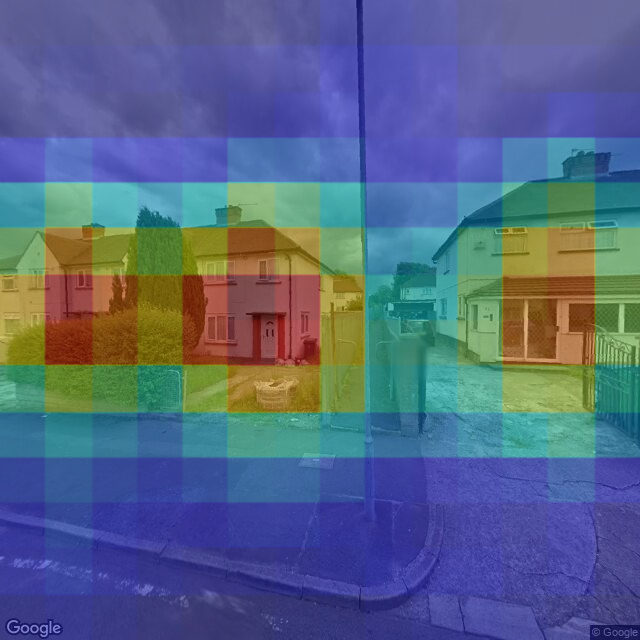

In [0]:
# https://github.com/CSAILVision/places365
# PlacesCNN to predict the scene category, attribute, and class activation map in a single pass
# by Bolei Zhou, sep 2, 2017
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
from scipy.misc import imresize as imresize
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(np.array(Image.fromarray(cam_img).resize(size_upsample)))
#         output_cam.append(imresize(cam_img, size_upsample))
    return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf


def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'wideresnet18_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    model.eval()



    # the following is deprecated, everything is migrated to python36

    ## if you encounter the UnicodeDecodeError when use python3 to load the model, add the following line will fix it. Thanks to @soravux
    #from functools import partial
    #import pickle
    #pickle.load = partial(pickle.load, encoding="latin1")
    #pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    #model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle)

    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model
# --------------------------------------------------------------------------------------------------------------------------


# 20530
for j in range(len(samplelabeled)-12,len(samplelabeled)-11):
  try:
    # load the labels
    classes, labels_IO, labels_attribute, W_attribute = load_labels()

    # load the model
    features_blobs = []
    model = load_model()

    # load the transformer
    tf = returnTF() # image transformer

    # get the softmax weight
    params = list(model.parameters())
    weight_softmax = params[-2].data.numpy()
    weight_softmax[weight_softmax<0] = 0

    # load the test image
    name = str(samplelabeled.iloc[j,5])
    img_url = '/content/gdrive/My Drive/MScthesis/randomdataset/'+ name +'.jpg'
    os.system('wget %s -q -O test.jpg' % img_url)
    img = Image.open(img_url)
    input_img = V(tf(img).unsqueeze(0))

    # forward pass
    logit = model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()

    print('RESULT ON ' + img_url)

    # output the IO prediction
    io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
    if io_image < 0.5:
      print('--TYPE OF ENVIRONMENT: indoor')
      print(j)
      # If this is image is taken indoor, we need to delete it
      samplelabeled.drop(samplelabeled.index[[j]],inplace=True)# remove in csv file
      os.remove(img_url) #delete the image file

    elif probs[0]<0.072:# the threshold for unavailable image
      samplelabeled.drop(samplelabeled.index[[j]],inplace=True)
      os.remove(img_url) # delete the unavailable
      print(j) #outdoor
    #       print('--TYPE OF ENVIRONMENT: outdoor')
    


    # output the prediction of scene category
    print('--SCENE CATEGORIES:')
    exist=0
    for i in range(0, 5):
      if ((classes[idx[i]].find('apartment_building/outdoor'))!=-1)|\
      ((classes[idx[i]].find('amusement_arcade'))!=-1)|\
      ((classes[idx[i]].find('amusement_park'))!=-1)|\
      ((classes[idx[i]].find('bakery/shop'))!=-1)|\
      ((classes[idx[i]].find('balcony/exterior'))!=-1)|\
      ((classes[idx[i]].find('beach_house'))!=-1)|\
      ((classes[idx[i]].find('barn'))!=-1)|\
      ((classes[idx[i]].find('building_facade'))!=-1)|\
      ((classes[idx[i]].find('boathouse'))!=-1)|\
      ((classes[idx[i]].find('cabin/outdoor'))!=-1)|\
      ((classes[idx[i]].find('chalet'))!=-1)|\
      ((classes[idx[i]].find('cottage'))!=-1)|\
      ((classes[idx[i]].find('courtyard'))!=-1)|\
      ((classes[idx[i]].find('campus'))!=-1)|\
      ((classes[idx[i]].find('castle'))!=-1)|\
      ((classes[idx[i]].find('church/outdoor'))!=-1)|\
      ((classes[idx[i]].find('courthouse'))!=-1)|\
      ((classes[idx[i]].find('embassy'))!=-1)|\
      ((classes[idx[i]].find('fire_station'))!=-1)|\
      ((classes[idx[i]].find('gas_station'))!=-1)|\
      ((classes[idx[i]].find('garage/outdoor'))!=-1)|\
      ((classes[idx[i]].find('general_store/outdoor'))!=-1)|\
      ((classes[idx[i]].find('gift_shop'))!=-1)|\
      ((classes[idx[i]].find('hangar/outdoor'))!=-1)|\
      ((classes[idx[i]].find('house'))!=-1)|\
      ((classes[idx[i]].find('hospital'))!=-1)|\
      ((classes[idx[i]].find('hotel/outdoor'))!=-1)|\
      ((classes[idx[i]].find('hunting_lodge/outdoor'))!=-1)|\
      ((classes[idx[i]].find('industrial_area'))!=-1)|\
      ((classes[idx[i]].find('inn/outdoor'))!=-1)|\
      ((classes[idx[i]].find('loading_dock'))!=-1)|\
      ((classes[idx[i]].find('library/outdoor'))!=-1)|\
      ((classes[idx[i]].find('market/outdoor'))!=-1)|\
      ((classes[idx[i]].find('museum/outdoor'))!=-1)|\
      ((classes[idx[i]].find('mansion'))!=-1)|\
      ((classes[idx[i]].find('manufactured_home'))!=-1)|\
      ((classes[idx[i]].find('market/outdoor'))!=-1)|\
      ((classes[idx[i]].find('office_building'))!=-1)|\
      ((classes[idx[i]].find('oast_house'))!=-1)|\
      ((classes[idx[i]].find('parking_garage/outdoor'))!=-1)|\
      ((classes[idx[i]].find('synagogue/outdoor'))!=-1)|\
      ((classes[idx[i]].find('residential_neighborhood'))!=-1)|\
      ((classes[idx[i]].find('shopfront'))!=-1)|\
      ((classes[idx[i]].find('skyscraper'))!=-1)|\
      ((classes[idx[i]].find('stage/outdoor'))!=-1):
        exist=1
        
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    if exist==0:
      samplelabeled.drop(samplelabeled.index[[j]],inplace=True)
      os.remove(img_url)
      print('this image does not include building')
      print(j)
    # output the scene attributes
    responses_attribute = W_attribute.dot(features_blobs[1])
    idx_a = np.argsort(responses_attribute)
    print('--SCENE ATTRIBUTES:')
    print(j)
    print(', '.join([labels_attribute[idx_a[i]] for i in range(-1,-10,-1)]))
    samplelabeled.to_csv('/content/gdrive/My Drive/MScthesis/ukpostcodessamplelabeled.csv',index=False)
    print('Saved')
  except OSError:
    print('file does not exist!')
    dir = r'/content/gdrive/My Drive/MScthesis/randomdataset'
    specify_str = str(name.split('_')[0])
    results = []
    folders = [dir]
    
    for folder in folders :
        # put all the files into folders
        folders += [os.path.join(folder, x) for x in os.listdir(folder) \
                    if os.path.isdir(os.path.join(folder, x))]
        # put all satisfy condition file address into results
        results += [os.path.relpath(os.path.join(folder, x), start = dir) \
                    for x in os.listdir(folder) \
                    if os.path.isfile(os.path.join(folder, x)) and specify_str in x]
    if(len(results)==1):
      print('former file name is /content/gdrive/My Drive/MScthesis/randomdataset/' + str(results[0] + '\n'))
      print('change file name to /content/gdrive/My Drive/MScthesis/randomdataset/' + samplelabeled.iloc[j,5] + '.jpg')
      print(j)
      os.rename('/content/gdrive/My Drive/MScthesis/randomdataset/' + str(results[0]) ,'/content/gdrive/My Drive/MScthesis/randomdataset/' + samplelabeled.iloc[j,5] + '.jpg')
    if(len(results)==0):
      print(j)
      samplelabeled.drop(samplelabeled.index[[j]],inplace=True)
  except IOError:
    print('file does not exist!')
    dir = r'/content/gdrive/My Drive/MScthesis/randomdataset'
    specify_str = str(name.split('_')[0])
    results = []
    folders = [dir]
    for folder in folders :
        # put all the files into folders
        folders += [os.path.join(folder, x) for x in os.listdir(folder) \
                    if os.path.isdir(os.path.join(folder, x))]
        # put all satisfy condition file address into results
        results += [os.path.relpath(os.path.join(folder, x), start = dir) \
                    for x in os.listdir(folder) \
                    if os.path.isfile(os.path.join(folder, x)) and specify_str in x]
    if(len(results)==1):
      print('former file name is /content/gdrive/My Drive/MScthesis/randomdataset/' + str(results[0] + '\n'))
      print('change file name to /content/gdrive/My Drive/MScthesis/randomdataset/' + samplelabeled.iloc[j,5] + '.jpg')
      print(j)
      os.rename('/content/gdrive/My Drive/MScthesis/randomdataset/' + str(results[0]) ,'/content/gdrive/My Drive/MScthesis/randomdataset/' + samplelabeled.iloc[j,5] + '.jpg')
    if(len(results)==0):
      print(j)
      samplelabeled.drop(samplelabeled.index[[j]],inplace=True)
# # generate class activation mapping
print('Class activation map is saved as cam.jpg')
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
# img = cv2.imread(img_url)
# height, width, _ = img.shape
# heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
# result = heatmap * 0.4 + img * 0.5
# cv2.imwrite('cam.jpg', result)
# cv2_imshow(result)

In [0]:
samplelabeled.to_csv('/content/gdrive/My Drive/MScthesis/ukpostcodessamplelabeled.csv',index=False)

In [0]:
classes

('airfield',
 'airplane_cabin',
 'airport_terminal',
 'alcove',
 'alley',
 'amphitheater',
 'amusement_arcade',
 'amusement_park',
 'apartment_building/outdoor',
 'aquarium',
 'aqueduct',
 'arcade',
 'arch',
 'archaelogical_excavation',
 'archive',
 'arena/hockey',
 'arena/performance',
 'arena/rodeo',
 'army_base',
 'art_gallery',
 'art_school',
 'art_studio',
 'artists_loft',
 'assembly_line',
 'athletic_field/outdoor',
 'atrium/public',
 'attic',
 'auditorium',
 'auto_factory',
 'auto_showroom',
 'badlands',
 'bakery/shop',
 'balcony/exterior',
 'balcony/interior',
 'ball_pit',
 'ballroom',
 'bamboo_forest',
 'bank_vault',
 'banquet_hall',
 'bar',
 'barn',
 'barndoor',
 'baseball_field',
 'basement',
 'basketball_court/indoor',
 'bathroom',
 'bazaar/indoor',
 'bazaar/outdoor',
 'beach',
 'beach_house',
 'beauty_salon',
 'bedchamber',
 'bedroom',
 'beer_garden',
 'beer_hall',
 'berth',
 'biology_laboratory',
 'boardwalk',
 'boat_deck',
 'boathouse',
 'bookstore',
 'booth/indoor',
 'b

In [0]:
cv2_imshow(result)

Use  CNN pre-trained on Place365 dataset

## Prepare training data

In [0]:
filenames = os.listdir("/content/gdrive/My Drive/MScthesis/train/residential")
categories = []
for filename in filenames:
    # category = filename.split('.')[0]
    # if category == 'dog':
  categories.append('residential')
    # else:
        # categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,horizontalflip_902285_LL12 0RR_53.091274183177...,residential
1,horizontalflip_902432_LL11 5HX_53.068891638635...,residential
2,horizontalflip_903094_LL11 4NT_53.071513_-3.01...,residential
3,horizontalflip_902624_LL11 5YX_53.071481233759...,residential
4,horizontalflip_903357_LL11 2NE_53.054922609988...,residential


In [0]:
filenames = os.listdir("/content/gdrive/My Drive/MScthesis/validation/residential")
categories = []
for filename in filenames:
    # category = filename.split('.')[0]
    # if category == 'dog':
  categories.append('residential')
    # else:
        # categories.append(0)

df1 = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df1.head()

,filename,category
0,1000_AB24 1XJ_57.16906756_-2.091179355_100.jpg,residential
1,102200_W4 5AQ_51.5011881700671_-0.266109603320...,residential
2,102009_W4 5XA_51.5027165673784_-0.264264940997...,residential
3,100685_W6 0YL_51.4931026580515_-0.227521576677...,residential
4,101582_W5 2LL_51.5183350470459_-0.294659_100.jpg,residential


In [0]:
filenames = os.listdir("/content/gdrive/My Drive/MScthesis/test/residential")
categories = []
for filename in filenames:
    # category = filename.split('.')[0]
    # if category == 'dog':
  categories.append('residential')
    # else:
        # categories.append(0)

df2 = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df2.head()

,filename,category
0,103631_W3 6PB_51.5137944384259_-0.267735_100.jpg,residential
1,118151_W10 5TF_51.519653377622795_-0.207147484...,residential
2,118562_W10 4DL_51.52836951912522_-0.2120239539...,residential
3,181868_TN37 6BP_50.8546364507837_0.56329076162...,residential
4,182346_TN34 3TF_50.8664178987749_0.58575394823...,residential


In [0]:
filenames = os.listdir("/content/gdrive/My Drive/MScthesis/train/nonresidential")
categories = []
for filename in filenames:
    # category = filename.split('.')[0]
    # if category == 'dog':
  categories.append('nonresidential')
    # else:
        # categories.append(0)

df3 = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df3.head()

,filename,category
0,horizontalflip_594741_PA16 7UJ_55.958474101067...,nonresidential
1,blur_594741_PA16 7UJ_55.9584741010674_-4.77729...,nonresidential
2,unsharp_594741_PA16 7UJ_55.9584741010674_-4.77...,nonresidential
3,edgeEnhance_594741_PA16 7UJ_55.9584741010674_-...,nonresidential
4,horizontalflip_595614_PA15 4AX_55.942330000000...,nonresidential


In [0]:
filenames = os.listdir("/content/gdrive/My Drive/MScthesis/validation/nonresidential")
categories = []
for filename in filenames:
    # category = filename.split('.')[0]
    # if category == 'dog':
  categories.append('nonresidential')
    # else:
        # categories.append(0)

df4 = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df4.head()

,filename,category
0,250202_SW17 9TR_51.422486558529606_-0.15881284...,nonresidential
1,262806_ST5 1PN_53.0108302814886_-2.226531_100.jpg,nonresidential
2,255970_SW11 3UL_51.465478000000004_-0.18281_10...,nonresidential
3,252355_SW16 2EL_51.425921995267295_-0.12592120...,nonresidential
4,254757_SW12 8XZ_51.4463723486207_-0.1514770461...,nonresidential


In [0]:
filenames = os.listdir("/content/gdrive/My Drive/MScthesis/test/nonresidential")
categories = []
for filename in filenames:
    # category = filename.split('.')[0]
    # if category == 'dog':
  categories.append('nonresidential')
    # else:
        # categories.append(0)

df5 = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df5.head()

,filename,category
0,100172_W7 1AG_51.522703_-0.33781300000000003_1...,nonresidential
1,10432_YO25 9UF_53.9332837675626_-0.55971948397...,nonresidential
2,104559_W2 5QS_51.518818722638905_-0.1961105502...,nonresidential
3,100878_W6 0ED_51.4932911363791_-0.225713568139...,nonresidential
4,103977_W3 6FN_51.5004941689812_-0.276984999790...,nonresidential


In [0]:
df6=pd.concat([df,df1,df2,df3,df4,df5],ignore_index=True)

In [0]:
import seaborn as sns

Text(0.5, 1.02, 'Count of images by class')

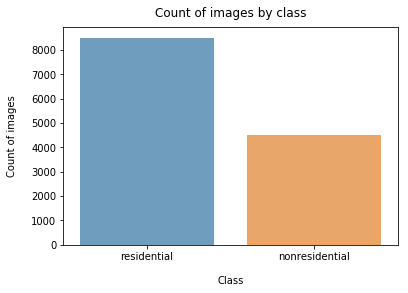

In [0]:
# df6['category'].value_counts().plot(kind='barh',facecolor='gray')
sns.barplot(df6['category'].value_counts().index, df6['category'].value_counts(), alpha=0.7)

plt.ylabel("Count of images", labelpad=14)
plt.xlabel("Class", labelpad=14)
plt.title("Count of images by class", y=1.02)

In [0]:
df2.to_csv('/content/gdrive/My Drive/MScthesis/totaltraindata.csv',index=False)

## Prepare training set, validation set, and test set 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Mounted at /content/gdrive


Using TensorFlow backend.


In [0]:
osplaceslabeled=pd.read_excel('/content/gdrive/My Drive/MScthesis/osplaceslabeled.xlsx')

In [0]:
osplaces["os places label"]=osplaces['os places label'].astype("str")

label the data using osplaces classification description

In [0]:
for i in range(len(osplaces)):
  if (osplaces.iloc[i,7].find("Residential")!=-1)|\
  (osplaces.iloc[i,7].find("Ancillary Building")!=-1)|\
  (osplaces.iloc[i,7].find("Car Park Space")!=-1)|\
  (osplaces.iloc[i,7].find("Allocated Parking")!=-1)|\
  (osplaces.iloc[i,7].find("Dwelling")!=-1)|\
  (osplaces.iloc[i,7].find("Caravan")!=-1)|\
  (osplaces.iloc[i,7].find("Detached")!=-1)|\
  (osplaces.iloc[i,7].find("Terraced")!=-1)|\
  (osplaces.iloc[i,7].find("Flat")!=-1)|\
  (osplaces.iloc[i,7].find("Terraced")!=-1)|\
  (osplaces.iloc[i,7].find("House Boat")!=-1)|\
  (osplaces.iloc[i,7].find("Sheltered Accommodation")!=-1)|\
  (osplaces.iloc[i,7].find("Privately Owned Holiday Caravan / Chalet")!=-1)|\
  (osplaces.iloc[i,7].find("HMO")!=-1)|\
  (osplaces.iloc[i,7].find("Residential Institution")!=-1)|\
  (osplaces.iloc[i,7].find("Care / Nursing Home")!=-1)|\
  (osplaces.iloc[i,7].find("Communal Residence")!=-1)|\
  (osplaces.iloc[i,7].find("Non-Commercial Lodgings")!=-1)|\
  (osplaces.iloc[i,7].find("Religious Community")!=-1)|\
  (osplaces.iloc[i,7].find("Residential Education")!=-1)|\
  (osplaces.iloc[i,7].find("Semi-Detached")!=-1)|\
  (osplaces.iloc[i,7].find("Lock-Up Garage / Garage Court")!=-1)|\
  (osplaces.iloc[i,7].find("House In Multiple Occupation")!=-1)|\
  (osplaces.iloc[i,7].find("Accommodation")!=-1):
    osplaces.loc[i,'label']=int(1)
  else:
    osplaces.loc[i,'label']=int(0)

In [0]:
osplaceslabeled.iloc[1:5,]

,id,postcode,latitude,longitude,label,file name,originalpostcode,os places label,resnet label,dataset belonging
1,1048599.0,HS12TD,58.214155,-6.378647,0.0,1048599_HS1 2TD_58.2141547666804_-6.3786473538...,HS1 2TD,Dwelling,NaN,NaN
2,1745598.0,BT828AQ,54.827306,-7.462853,1.0,1745598_BT82 8AQ_54.82730600000001_-7.462853_100,BT82 8AQ,Detached,NaN,NaN
3,1501185.0,CA142YD,54.643604,-3.555125,1.0,1501185_CA14 2YD_54.643604240616796_-3.555125_100,CA14 2YD,Semi-Detached,NaN,NaN
4,1485324.0,CB62RQ,52.390644,0.126940,0.0,1485324_CB6 2RQ_52.3906444294214_0.12694015628...,CB6 2RQ,Detached,NaN,NaN


In [0]:
osplaces.to_excel('/content/gdrive/My Drive/MScthesis/osplaceslabeled.xlsx',index=False)

In [0]:
import os
import os.path
import shutil 

In [0]:
target = '/content/gdrive/My Drive/MScthesis/residential'
for i in range(109,len(osplaceslabeled)-1):
  try:
    if osplaceslabeled.iloc[i,4]==1:#this image is residential
      filename = str(osplaceslabeled.iloc[i,5])
      source = '/content/gdrive/My Drive/MScthesis/randomdataset/'+ filename + '.jpg'
      target = '/content/gdrive/My Drive/MScthesis/residential'
      shutil.copy(source, target)
    print(i)
  except FileNotFoundError:
    pass

#     assert not os.path.isabs(source)
#     target = os.path.join(target, os.path.dirname(source))


In [0]:
import scipy
from scipy import ndimage
import PIL
import imageio
import os
data_dir = '/content/gdrive/My Drive/MScthesis/validation/nonresidential/'
imgs = os.listdir(data_dir)
num = len(imgs)
for i in range(num):
  if ((str(imgs[i]).find('sobel'))!=-1):
    os.remove(data_dir+imgs[i])
    print(i)


data augmentation Sobel filter

In [0]:
import scipy
from scipy import ndimage
import PIL
import imageio
import os
data_dir = '/content/gdrive/My Drive/MScthesis/train/residential/'
imgs = os.listdir(data_dir)
num = len(imgs)
for i in range(num):
  im=imageio.imread(data_dir+imgs[i])
  im=im.astype('int32')
  dx = ndimage.sobel(im, 1)  # horizontal derivative
  dy = ndimage.sobel(im, 0)  # vertical derivative
  mag = np.hypot(dx, dy)  # magnitude
  mag *= 255.0 / np.max(mag)  # normalize (Q&D)
  imageio.imwrite(data_dir+"sobel_"+imgs[i], mag)
  print('save '+str(i))

Output hidden; open in https://colab.research.google.com to view.